In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from benfordslaw import benfordslaw
bl = benfordslaw(verbose=0)

In [2]:
#import requests

# Data downloaded as XLS from https://results.enr.clarityelections.com/GA/Fulton/105430/web.264614/#/detail/1
# worksheet 1 saved to csv to ga_fulton_county.csv

#data = pd.read_csv('ga_fulton_county.csv', skiprows=1)

In [3]:
 data = pd.read_csv('data/ga_fulton_county.csv', skiprows=2)
data.head(3)

,County,Registered Voters,Election Day Votes,Advanced Voting Votes,Absentee by Mail Votes,Provisional Votes,Total Votes,Election Day Votes.1,Advanced Voting Votes.1,Absentee by Mail Votes.1,Provisional Votes.1,Total Votes.1,Election Day Votes.2,Advanced Voting Votes.2,Absentee by Mail Votes.2,Provisional Votes.2,Total Votes.2,Total
0,01A,0,41,143,50,0,234,160,1638,703,0,2501,3,10,9,0,22,2757
1,01B,0,79,158,57,0,294,242,1824,878,0,2944,11,16,15,0,42,3280
2,01C,0,21,20,8,0,49,180,369,161,0,710,4,6,3,0,13,772


In [4]:
data = data[data.columns[[0, 6, 11, 16]]]

# first column is mislabled (not County)
data.columns = ['Precinct', 'Donald Trump', 'Joe Biden', 'Jo Jorgensen']

In [5]:
data = data.set_index('Precinct')
data.head(3)

,Donald Trump,Joe Biden,Jo Jorgensen
Precinct,,,
01A,234,2501,22
01B,294,2944,42
01C,49,710,13


In [6]:
unstacked_data = data.unstack().reset_index().rename(
    columns={0: 'count', 'level_0': 'candidate'})
unstacked_data = unstacked_data[['candidate', 'count', 'Precinct']]
unstacked_data['count'] = unstacked_data['count'].astype(int)
unstacked_data.head(3)

,candidate,count,Precinct
0,Donald Trump,234,01A
1,Donald Trump,294,01B
2,Donald Trump,49,01C


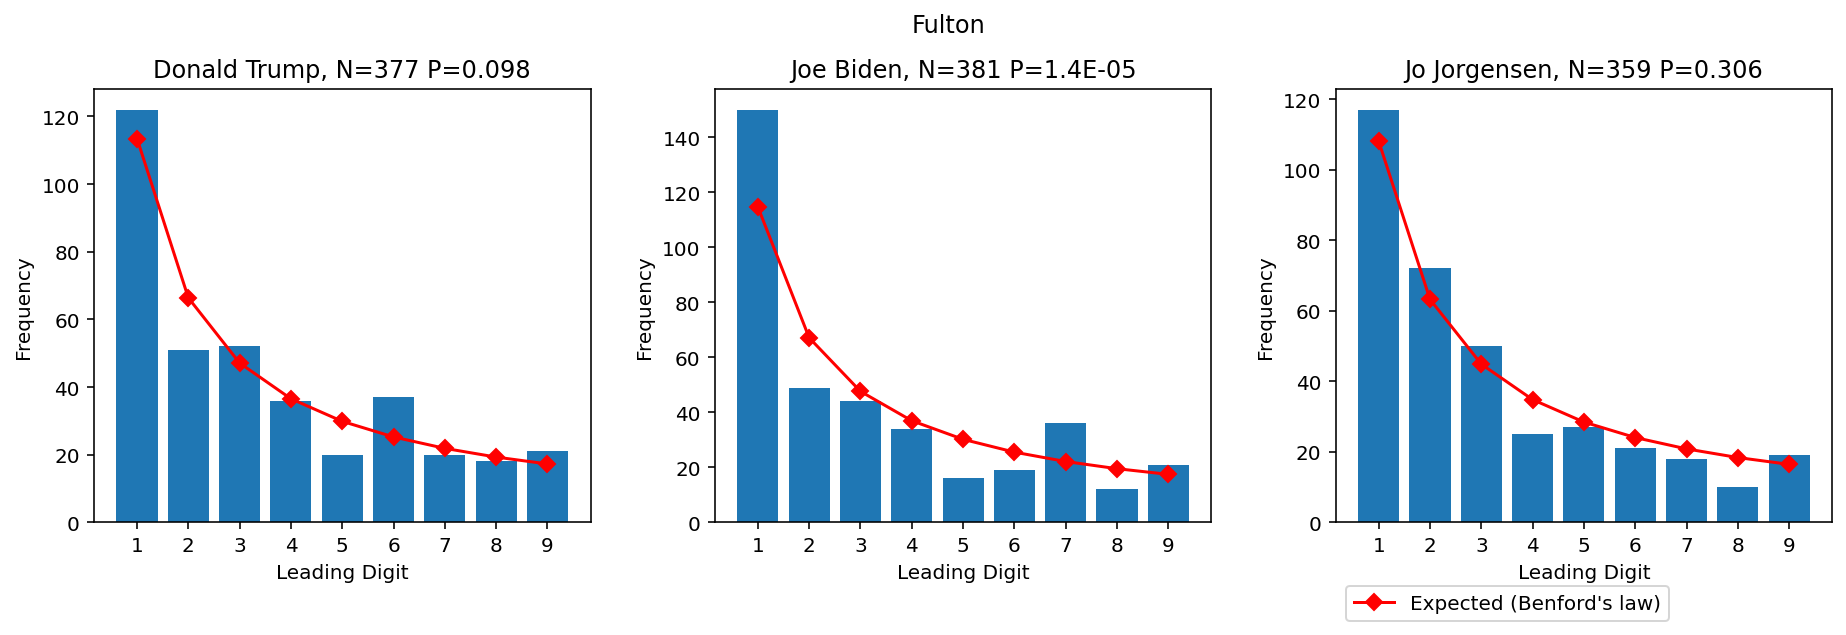

In [7]:

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.tight_layout(rect=[0.1, 0.0, 0.9, 0.9])
plt.subplots_adjust(hspace=0.4, wspace=0.25)

axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()
digit = np.arange(1, 10)

for i in range(len(candidates)):

    ax = axs[i]
    candidate = candidates[i]
    
    N = len(data[data[candidate] > 0])
    
    # expected distribution, from benford's law, normalize by non-zero counts
    expected = np.log10(1 + 1/digit) * N

    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'Precinct']).sum()
    
    counts = cur_data.loc[candidate]['count']
    P = bl.fit(np.array(counts.astype(int).tolist()))['P']
    
    digits = counts.astype(str).str[0].astype(int)
    digits = digits[digits > 0]
    
    v = digits.value_counts()
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, 10))

    if P < .001:
        ax.set_title("%s, N=%d P=%.1E" % (candidate, N,P))
    else:
        ax.set_title("%s, N=%d P=%0.3f" % (candidate, N,P))
    
    ax.plot(digit, expected, marker='D', color='red', label='Expected (Benford\'s law)')
    ax.set_xlabel("Leading Digit")
    ax.set_ylabel("Frequency")
    
plt.legend(loc=3, bbox_to_anchor=(0.0, -0.25))
plt.suptitle("Fulton")
plt.savefig('images/fulton.png')